# Тестовое задание от predictor
Ищем инсайты в базе данных с чеками

In [1]:
import sys
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
from matplotlib import pyplot as plt
import plotly.graph_objects as go

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [2]:
# Читаем csv файл, меняем тип колонок.

data_path_file = 'data/part-00000-tid-8370008162403743937-fb75df88-9cee-4f18-abe9-e15683243574-7517-1-c000.csv' 

df = pd.read_csv(data_path_file)
df.iloc[:, [4,6,7,8,9,10,11,12]] = (df.iloc[:, [4,6,7,8,9,10,11,12]]
                                    .apply(pd.to_numeric, errors='coerce'))

df['d_date'] = pd.to_datetime(df['d_date'])


## EDA - первичный (разведочный) анализ данных
Используем библиотеку ProfileReport  
!!! Готовый репорт можно скачать здесь: https://disk.yandex.ru/d/i5ZEtkIjS-xsCg


In [3]:
# Генерируем профайл репорт для первичного анализа базы
profile = ProfileReport(df.sample(n=100000, random_state=32), title="Test task Profiling Report")
profile.to_file("data/test_task_report.html")

# Получившийся файл можно скачать по ссылке: https://disk.yandex.ru/d/i5ZEtkIjS-xsCg

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000000 entries, 0 to 9999999
Data columns (total 21 columns):
 #   Column           Dtype         
---  ------           -----         
 0   receiptid        int64         
 1   kkt_sn           int64         
 2   d_date           datetime64[ns]
 3   name             object        
 4   amount           float64       
 5   unit             object        
 6   price            float64       
 7   cost             float64       
 8   nal              float64       
 9   electron         float64       
 10  avans            float64       
 11  credit           float64       
 12  vstrechpredst    float64       
 13  Тип региона      object        
 14  Имя региона      object        
 15  Тип города       object        
 16  Имя города       object        
 17  Тип улицы        object        
 18  Имя улицы        object        
 19  Тип номера дома  object        
 20  Номер дома       object        
dtypes: datetime64[ns](1), float64(

In [5]:
df.head()

,receiptid,kkt_sn,d_date,name,amount,unit,price,cost,nal,electron,avans,credit,vstrechpredst,Тип региона,Имя региона,Тип города,Имя города,Тип улицы,Имя улицы,Тип номера дома,Номер дома
0,61379295,108200088416,2018-06-07,0001 ДЕТСКИЙ ТРИКОТАЖ,1.0,--,450.0,450.0,450.0,0.0,0.0,0.0,0.0,обл,Новосибирская,г,Чулым,ул,Кооперативная,дом,"""=""""17"""""""
1,61379296,108200088416,2018-06-07,0001 ДЕТСКИЙ ТРИКОТАЖ,1.0,--,360.0,360.0,360.0,0.0,0.0,0.0,0.0,обл,Новосибирская,г,Чулым,ул,Кооперативная,дом,"""=""""17"""""""
2,61379301,108200088416,2018-06-07,0001 ДЕТСКИЙ ТРИКОТАЖ,1.0,--,250.0,250.0,250.0,0.0,0.0,0.0,0.0,обл,Новосибирская,г,Чулым,ул,Кооперативная,дом,"""=""""17"""""""
3,61429416,108200088416,2018-06-08,0001 ДЕТСКИЙ ТРИКОТАЖ,1.0,--,1500.0,1500.0,1500.0,0.0,0.0,0.0,0.0,обл,Новосибирская,г,Чулым,ул,Кооперативная,дом,"""=""""17"""""""
4,61431313,108200088416,2018-06-08,0001 ДЕТСКИЙ ТРИКОТАЖ,1.0,--,1870.0,1870.0,1870.0,0.0,0.0,0.0,0.0,обл,Новосибирская,г,Чулым,ул,Кооперативная,дом,"""=""""17"""""""


### Отсеиваем регионы с кол-вом чеков меньше 20 тыс

In [6]:
# Отсеиваем регионы с кол-вом чеков меньше 10 тыс
df_regions = (df[['Имя региона', 'receiptid']]
    .drop_duplicates()
    .groupby(by='Имя региона')
    .count() 
).sort_values(by='receiptid')    

regions = df_regions[df_regions['receiptid']>=20000].index.to_numpy()
regions = list(regions[regions!='0'])
regions[:10]

['Ивановская',
 'Псковская',
 'Костромская',
 'Карелия',
 'Калининградская',
 'Калужская',
 'Брянская',
 'Орловская',
 'Камчатский',
 'Владимирская']

## Анализируем суммарный доход регионов в разрезе типа платежа

In [7]:
dupl_cols = ['receiptid']
pay_type_cols = ['nal', 'electron', 'avans', 'credit']
region_col = ['Имя региона']

df_pay_type =  df.drop_duplicates(subset=dupl_cols).loc[: , dupl_cols+pay_type_cols+region_col]
mask = df_pay_type[pay_type_cols].sum(axis=1) <=0
df_pay_type = df_pay_type[~mask]


Text(0.5, 1.0, 'Доходы (суммы чеков) по регионам за весь период в разрезе типа платежа')

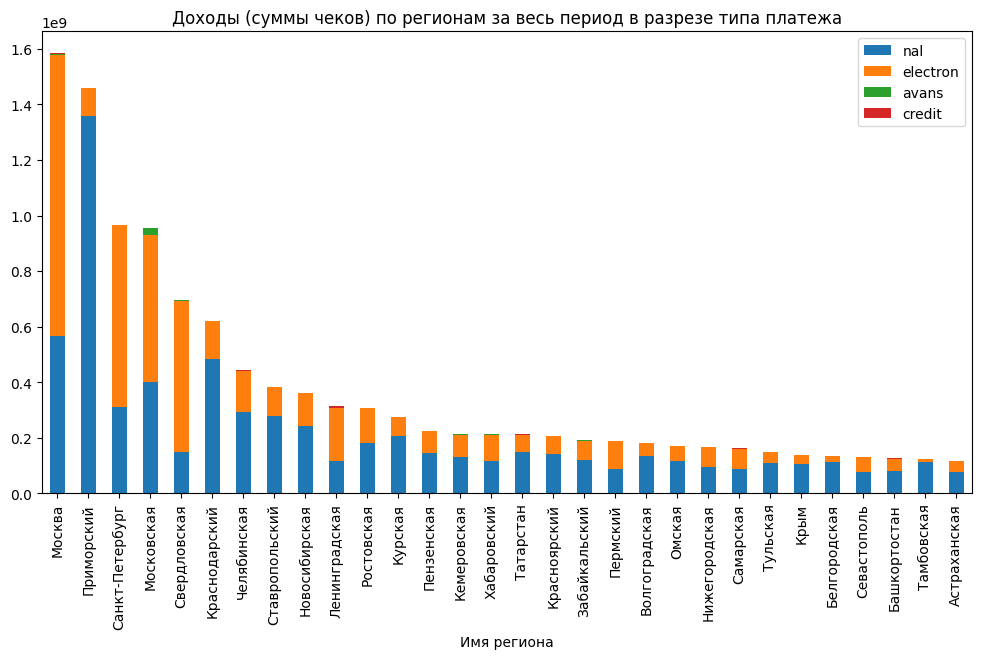

In [8]:
# Группировка по регионам
df_pay = (df_pay_type[region_col+pay_type_cols]
            .groupby(by=region_col).sum())
# Оставляем только регионы из списка regions
df_pay = df_pay.T.loc[:, regions].T

df_pay['total'] = df_pay[pay_type_cols].sum(axis=1)
df_pay = df_pay.sort_values(by='total', ascending=False)

# Строим барчарт
(df_pay[pay_type_cols].iloc[:30]
    .plot.bar(stacked=True, figsize=(12, 6)))
plt.title('Доходы (суммы чеков) по регионам за весь период в разрезе типа платежа')

## Анализируем зависимость средней суммы чека от региона в разрезе типа платежа

Text(0.5, 1.0, 'Средняя сумма чеков по регионам за весь период в разрезе типа платежа')

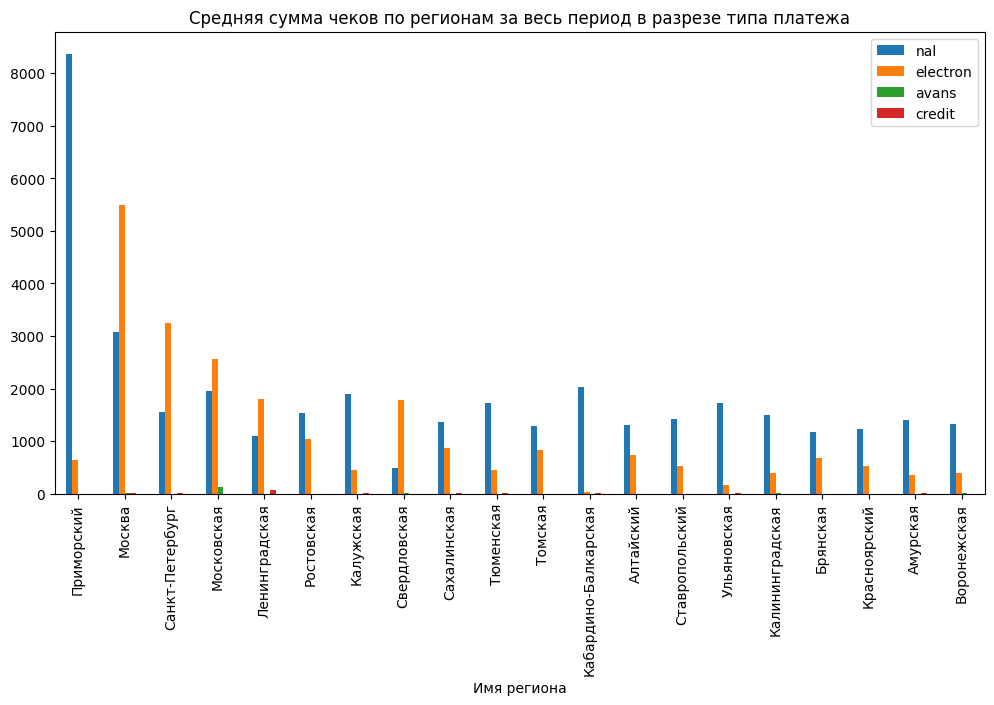

In [9]:
# Группировка по регионам
df_pay_type['total'] = df_pay_type[pay_type_cols].sum(axis=1)
df_pay = (df_pay_type[region_col+pay_type_cols+['total']]
            .groupby(by=region_col).mean())
# Оставляем только регионы из списка regions
df_pay = df_pay.T.loc[:, regions].T

df_pay = df_pay.sort_values(by='total', ascending=False)

# Строим барчарт
(df_pay[pay_type_cols].iloc[:20]
    .plot.bar(stacked=False, figsize=(12, 6)))
plt.title('Средняя сумма чеков по регионам за весь период в разрезе типа платежа')

## Анализируем распределение доходов по дням недели по регионам

In [10]:
dupl_cols = ['receiptid']
pay_type_cols = ['nal', 'electron', 'avans', 'credit']
region_col = ['Имя региона']
date_col = ['d_date']

df_wd_income = (df.drop_duplicates(subset=dupl_cols)
                .loc[: , date_col+ dupl_cols+pay_type_cols+region_col])
mask = df_wd_income[pay_type_cols].sum(axis=1) <=0
df_wd_income = df_wd_income[~mask]
df_wd_income['d_date'] = df_wd_income['d_date'].dt.day_name()

df_wd_income['total'] = df_wd_income[pay_type_cols].sum(axis=1)
df_wd_income = df_wd_income[['d_date', 'Имя региона', 'total']]
df_wd_income = df_wd_income.groupby(by=['d_date', 'Имя региона']).mean()
df_wd_income = df_wd_income.T.stack("Имя региона").droplevel(0,0).T.loc[:, regions].T.sort_index(ascending=False)
old_cols = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
new_cols = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']
df_wd_income = df_wd_income[old_cols]
df_wd_income.rename(columns=dict(zip(old_cols, new_cols)), inplace=True)

# Проводим нормирование по строкам (регионам), получаем процентное распределение 
# доходов по дням недели
df_wd_income = (100*df_wd_income.div(df_wd_income.sum(axis=1).to_numpy(), axis=0)).round(1)

# Фильтруем выбросы
df_wd_income = df_wd_income[(df_wd_income.max(axis=1)<25) & (df_wd_income.min(axis=1)>7)]

In [11]:
# Рисуем heatmap
fig = go.Figure(data=go.Heatmap(
        z=df_wd_income.values,
        x=df_wd_income.columns,
        y=df_wd_income.index,
        colorscale='Viridis'
))
        
fig.update_xaxes(side="top")

fig.update_layout(
    title='Доходы по дням недели и регионам в процентах к общей сумме за неделю по региону',
    width = 900, 
    height = 1800,
)


fig.show()